# Model Building
## Classification


In [33]:
# Import necessary libraries for data manipulation, machine learning models, and evaluation
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Machine learning models
import xgboost as xg
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


# Model evaluation
from sklearn.metrics import (
    mean_squared_error as MSE, 
    r2_score, 
    roc_curve, 
    roc_auc_score,
    precision_score, 
    recall_score, 
    f1_score
)


# Data splitting
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE


# Warnings suppression
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
# Set the style to dark background
plt.style.use('dark_background')  # Set the background to dark

# Optionally, you can adjust the color palette for better contrast
sns.set_palette('muted')  # Adjusts the color palette for visibility on a dark background
from joblib import dump, load



In [2]:
# Load the processed dataset and display it

DATA_PATH = "../data/processed_data.csv"
data = pd.read_csv(DATA_PATH)
data


,PopulationDensity,Development_Index,Waste_Index,target
0,122.299437,0.000000e+00,2.605571,0.063310
1,122.299437,0.000000e+00,2.605571,0.046733
2,122.299437,0.000000e+00,2.605571,132.859000
3,122.299437,0.000000e+00,2.605571,11.578376
4,93.677197,1.276450e+14,3.741093,0.206800
...,...,...,...,...
19888,122.299437,0.000000e+00,2.605571,0.092466
19889,122.299437,0.000000e+00,2.605571,89.908300
19890,122.299437,0.000000e+00,2.605571,18.901608
19891,122.299437,0.000000e+00,2.605571,307.307000


In [3]:
# Split the data into features (x) and target variable (y)
x = data.drop(["target"],axis = 1)
y = data["target"].values

In [4]:
# Split the data into training and testing sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)


In [5]:
# Function to convert 'target' values into binary class labels (0 for 'Dirty', 1 for 'Clean')

# 0 -> 'Dirty'
# 1 -> 'Clean'
def makeClass(y):
  y = [0 if x > 500 else 1 for x in y]
  return y

In [6]:
# Apply the makeClass function to both training and testing target values

y_train, y_test = makeClass(y_train),makeClass(y_test)


In [7]:
# Normalize the feature values using MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


In [8]:
# Function to create different machine learning models for classification

def createModels():
  xgBoost = xg.XGBClassifier(eval_metric="logloss")
  knn = KNeighborsClassifier()
  svc = SVC(probability=True)
  randomForest = RandomForestClassifier()
  adaBoost = AdaBoostClassifier()
  nb = GaussianNB()
  return ((xgBoost,"XGBoost Classifier"),(knn,"KNN Classifier"),(svc,"SVC Classifier"),(randomForest,"Random Forest Classifier"),(adaBoost,"AdaBoost Classifier"),(nb,"Naive Bayes Classifier"))

models = createModels()

# Train and evaluate the classification models, printing their accuracy on the test set

for model, name in models:
  model.fit(x_train,y_train)
  print(f"Accuracy of {name}: {model.score(x_test,y_test)}")


Accuracy of XGBoost Classifier: 0.9867627345844504
Accuracy of KNN Classifier: 0.9867627345844504
Accuracy of SVC Classifier: 0.9867627345844504
Accuracy of Random Forest Classifier: 0.9867627345844504
Accuracy of AdaBoost Classifier: 0.9867627345844504
Accuracy of Naive Bayes Classifier: 0.978887399463807


In [9]:
# Calculate and print ROC AUC scores for each classifier

for model,name in models:
  y_score = model.predict_proba(x_test)[:,1] 
  false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
  print(f'roc_auc_score for {name}: ', roc_auc_score(y_test, y_score))


roc_auc_score for XGBoost Classifier:  0.6303986621699759
roc_auc_score for KNN Classifier:  0.4648873355386894
roc_auc_score for SVC Classifier:  0.5368483613516727
roc_auc_score for Random Forest Classifier:  0.6305244061552219
roc_auc_score for AdaBoost Classifier:  0.6301213805614846
roc_auc_score for Naive Bayes Classifier:  0.6313218594633634


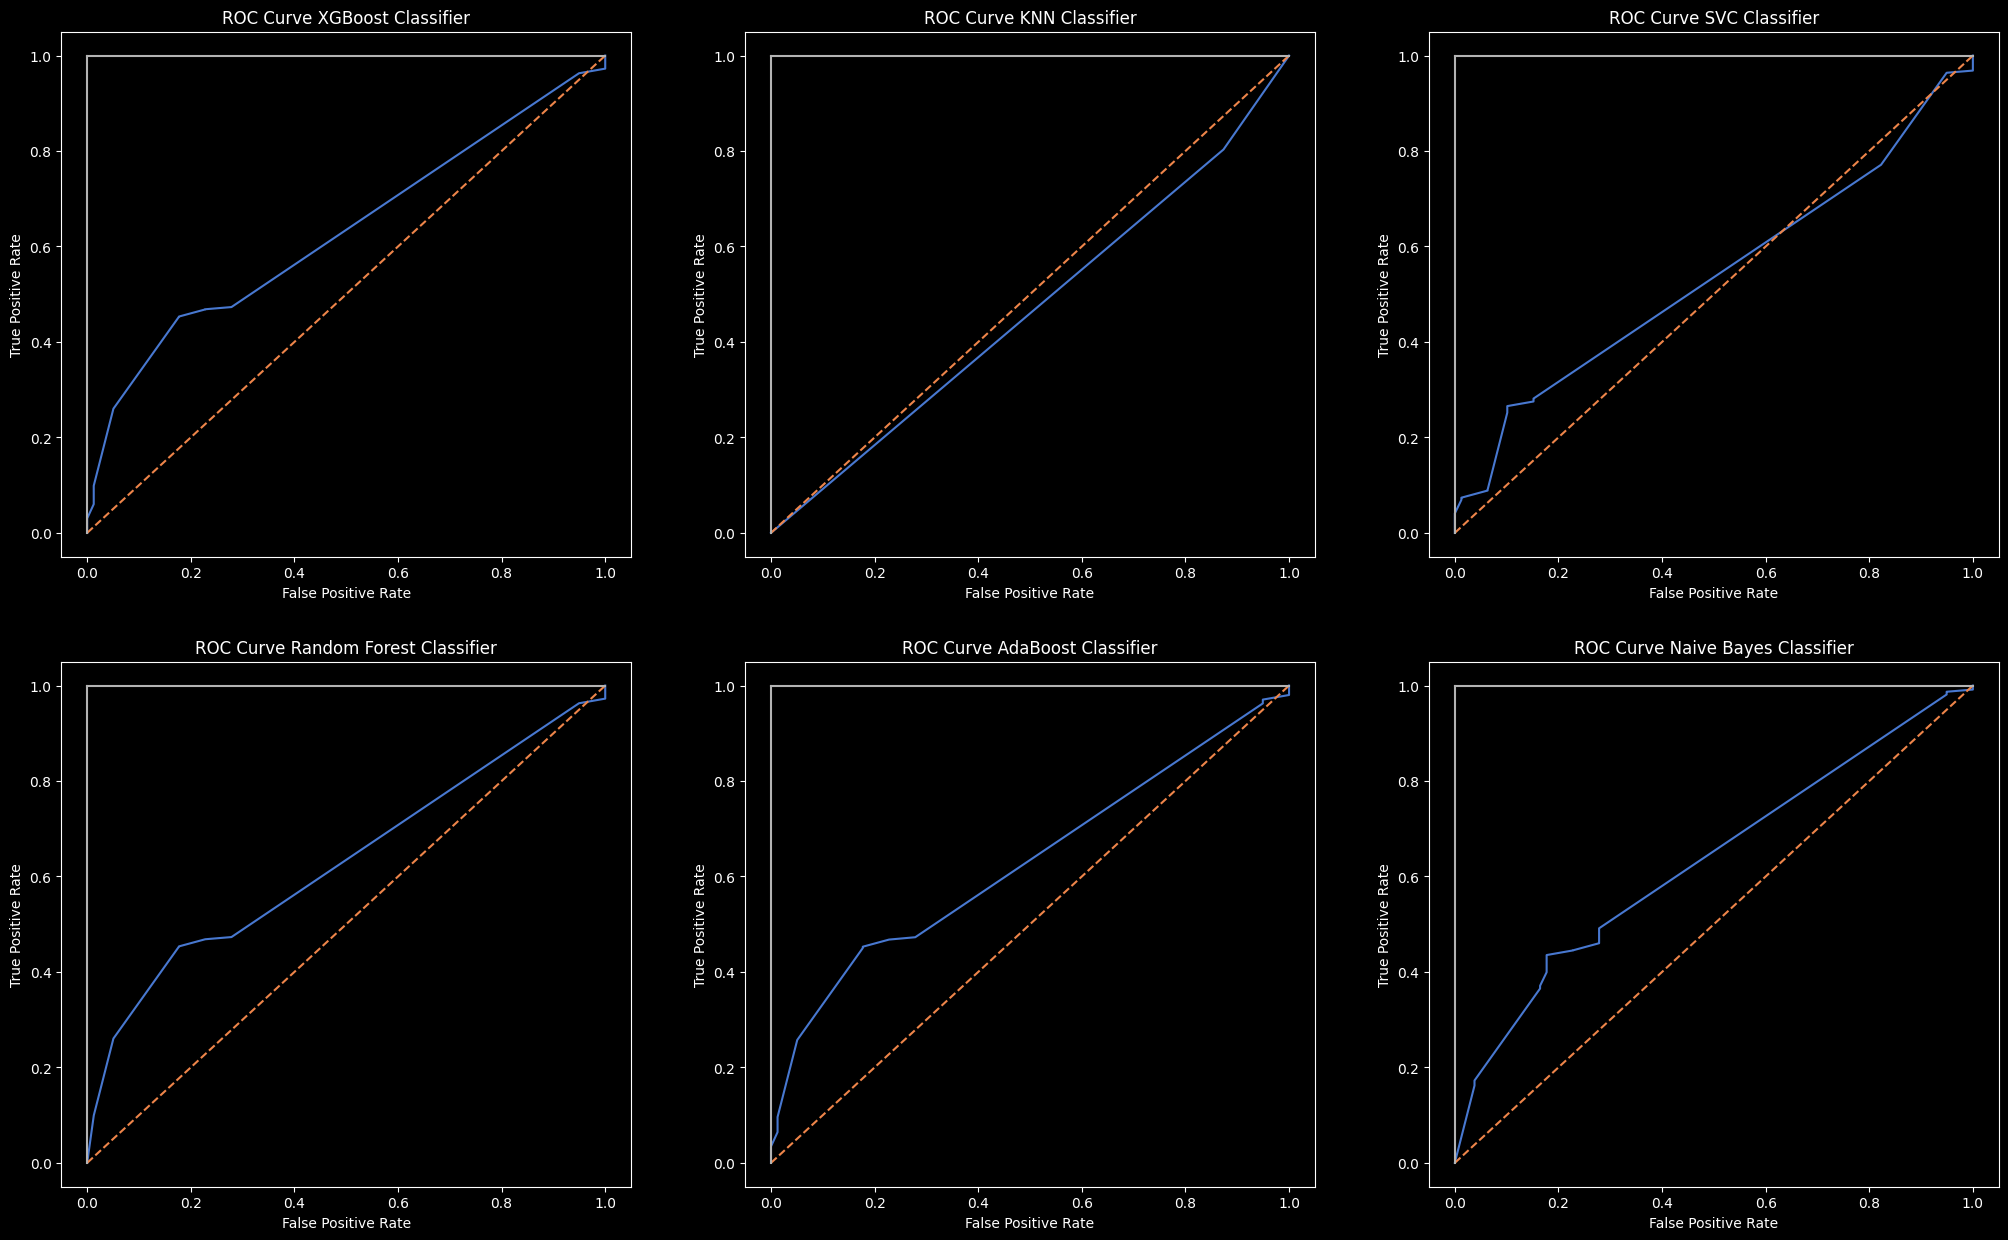

In [10]:
# Plot ROC curves for each classifier

plt.subplots(nrows=2,ncols=3,figsize = (25,15))
figurePos = 1
for model,name in models:
  plt.subplot(2,3,figurePos)
  figurePos += 1
  y_score = model.predict_proba(x_test)[:,1] 
  false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
  plt.title(f"ROC Curve {name}")
  plt.plot(false_positive_rate, true_positive_rate)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
plt.show()

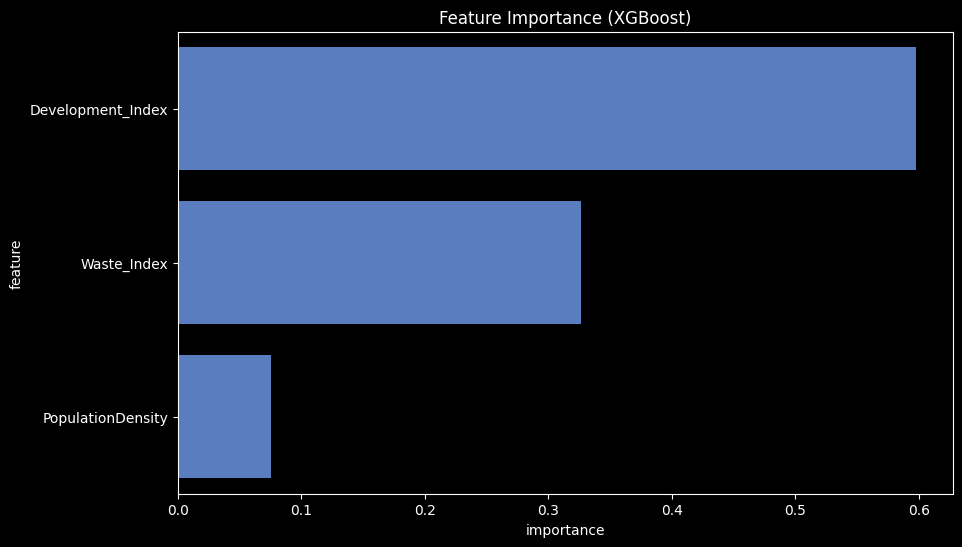

In [11]:
# Assign column names to x_train for feature importance plotting
x_train = pd.DataFrame(x_train, columns=["PopulationDensity", "Development_Index", "Waste_Index"])

# Train an XGBoost model and calculate feature importance
model = xg.XGBClassifier(eval_metric="logloss")

model.fit(x_train, y_train)

# Calculate feature importance
feat_imp = pd.DataFrame({'importance': model.feature_importances_})
feat_imp['feature'] = x_train.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title("Feature Importance (XGBoost)")
plt.show()


## Regression

In [12]:
# Split data again for regression model (train/test split)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)

# Apply the makeClass function to both training and testing target values
y_train, y_test = makeClass(y_train),makeClass(y_test)


smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [13]:
# Normalize the feature values again for regression

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


In [14]:
# Train an XGBoost regressor model

regressor = xg.XGBRegressor().fit(x_train,y_train)

In [15]:

# Predict target values on the test set using the regressor
preds = regressor.predict(x_test)


In [16]:
# Calculate and print regression metrics (MSE and R2 score)

mse = MSE(y_test,preds)
r2Score = r2_score(y_test,preds)

In [17]:
print("Metrics for XGBoost Regressor\n--------------------------")
print(f"MSE: {mse}\nRMSE: {mse ** (1/2)}\nR^2 Score: {r2Score}")

Metrics for XGBoost Regressor
--------------------------
MSE: 0.22105923084783044
RMSE: 0.4701693640038985
R^2 Score: -15.923790397735143


## Run Classifier By Features


In [18]:
# Initialize the KNN classifier

model = KNeighborsClassifier()

y = data["target"].values
x = data.drop(["target"],axis = 1)

def makeClass(y):
  y = ["Dirty" if x > 500 else "Clean" for x in y]
  return y


def fitData(x,y,model,columns):
  a = x[columns]
  x_train,x_test,y_train,y_test = train_test_split(a,y,test_size = 0.3,random_state=42)
  y_train, y_test = makeClass(y_train),makeClass(y_test)
  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.fit_transform(x_test)
  model.fit(x_train,y_train)
  return model.score(x_test,y_test)

usedCols = list()
scores = list()
for col in x.columns:
  usedCols.append(col)
  score = fitData(x,y,model,usedCols)
  scores.append(score)
  print(f"Accuracy with {col} Feature: {score}")
  print("-"*65)



Accuracy with PopulationDensity Feature: 0.9867627345844504
-----------------------------------------------------------------
Accuracy with Development_Index Feature: 0.9867627345844504
-----------------------------------------------------------------
Accuracy with Waste_Index Feature: 0.9867627345844504
-----------------------------------------------------------------


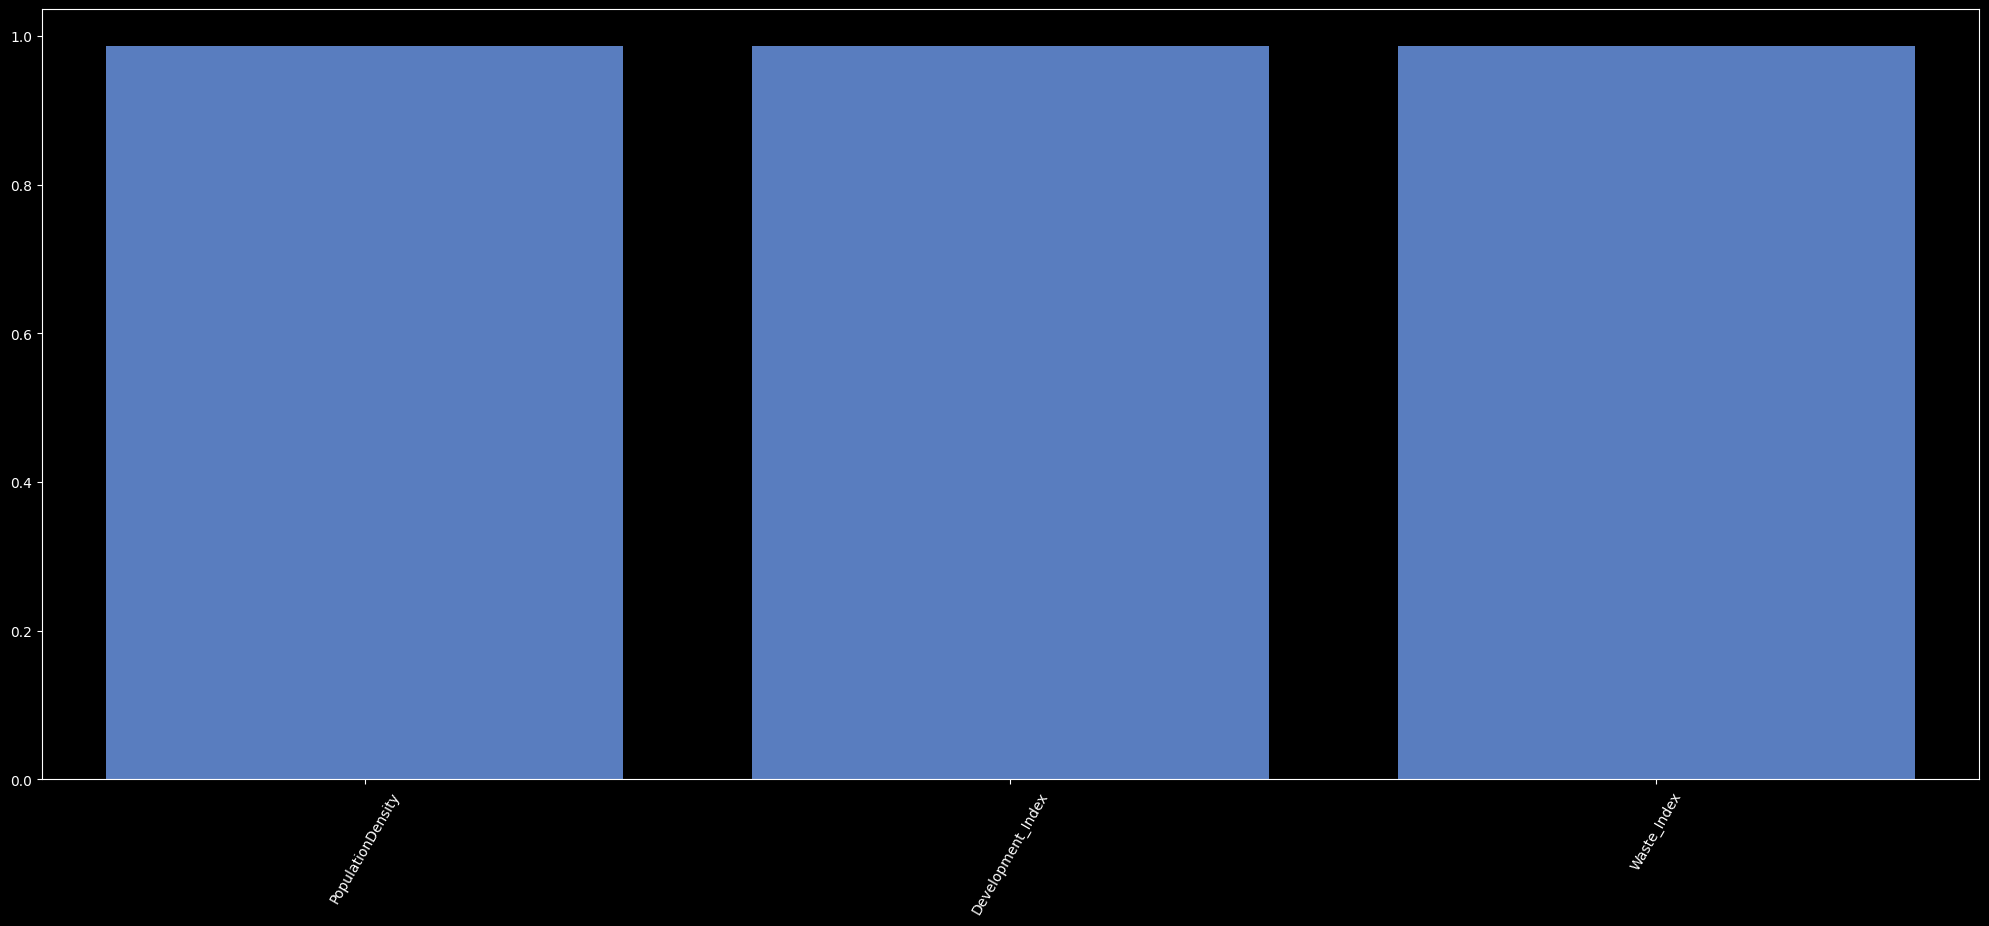

In [19]:
# Plot the feature-wise accuracy scores

plt.figure(figsize=(25,10))
sns.barplot(x=usedCols,y=scores)
plt.xticks(rotation=60)
plt.show()


# Hyperparameter Tuning and Cross-Validation for Classification Models
## Model Building with Hyperparameter Tuning

In [20]:
def tune_and_evaluate_model(model, param_grid, x_train, y_train, model_name):
    # Hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')  # n_jobs=1 to disable parallelism
    grid_search.fit(x_train, y_train)
    
    # Best parameters and best score
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")
    
    # Cross-validation score
    cross_val_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores for {model_name}: {cross_val_scores}")
    print(f"Mean cross-validation score for {model_name}: {cross_val_scores.mean()}")
    
    return grid_search.best_estimator_, grid_search.best_score_

## Model Evaluation: Tuning Hyperparameters and Cross-Validation
### XGBoost Classifier Hyperparameter Tuning

In [21]:
xgBoost = xg.XGBClassifier(eval_metric="logloss", use_label_encoder=False)
xgBoost_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

best_xgb_model, best_xgb_score = tune_and_evaluate_model(xgBoost, xgBoost_param_grid, x_train, y_train, "XGBoost")


/Users/mac/Desktop/Water-Quality-Analysis-ML/.water-quality-venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mac/Desktop/Water-Quality-Analysis-ML/.water-quality-venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mac/Desktop/Water-Quality-Analysis-ML/.water-quality-venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mac/Desktop/Water-Quality-Analysis-ML/.water-quality-v

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best score for XGBoost: 0.6704810495626823
Cross-validation scores for XGBoost: [0.67000729 0.66144315 0.67766035 0.66290087 0.68039359]
Mean cross-validation score for XGBoost: 0.6704810495626823


### KNN Classifier Hyperparameter Tuning


In [22]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
best_knn_model, best_knn_score = tune_and_evaluate_model(knn, knn_param_grid, x_train, y_train, "KNN")


Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNN: 0.5224489795918368
Cross-validation scores for KNN: [0.52259475 0.52350583 0.52113703 0.52350583 0.52150146]
Mean cross-validation score for KNN: 0.5224489795918368


### SVC Classifier Hyperparameter Tuning

In [23]:
svc = SVC(probability=True)
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale']
}
best_svc_model, best_svc_score = tune_and_evaluate_model(svc, svc_param_grid, x_train, y_train, "SVC")


Best parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVC: 0.6611151603498542
Cross-validation scores for SVC: [0.65925656 0.65816327 0.67164723 0.64996356 0.66654519]
Mean cross-validation score for SVC: 0.6611151603498542


### Random Forest Classifier Hyperparameter Tuning

In [24]:
randomForest = RandomForestClassifier()
randomForest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
best_rf_model, best_rf_score = tune_and_evaluate_model(randomForest, randomForest_param_grid, x_train, y_train, "Random Forest")


Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest: 0.670298833819242
Cross-validation scores for Random Forest: [0.67000729 0.66144315 0.67747813 0.66290087 0.68039359]
Mean cross-validation score for Random Forest: 0.6704446064139942


### AdaBoost Classifier Hyperparameter Tuning


In [25]:
adaBoost = AdaBoostClassifier()
adaBoost_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
best_ada_model, best_ada_score = tune_and_evaluate_model(adaBoost, adaBoost_param_grid, x_train, y_train, "AdaBoost")


Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 200}
Best score for AdaBoost: 0.668768221574344
Cross-validation scores for AdaBoost: [0.66818513 0.66016764 0.67693149 0.66034985 0.678207  ]
Mean cross-validation score for AdaBoost: 0.668768221574344


### Naive Bayes Classifier Hyperparameter Tuning

In [26]:
nb = GaussianNB()
# Naive Bayes doesn't have many hyperparameters to tune, but you can tune priors or var_smoothing if needed.
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}
best_nb_model, best_nb_score = tune_and_evaluate_model(nb, nb_param_grid, x_train, y_train, "Naive Bayes")


Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best score for Naive Bayes: 0.610131195335277
Cross-validation scores for Naive Bayes: [0.5983965  0.61534257 0.62718659 0.60404519 0.60568513]
Mean cross-validation score for Naive Bayes: 0.610131195335277


## Comparison of All Models' Performance

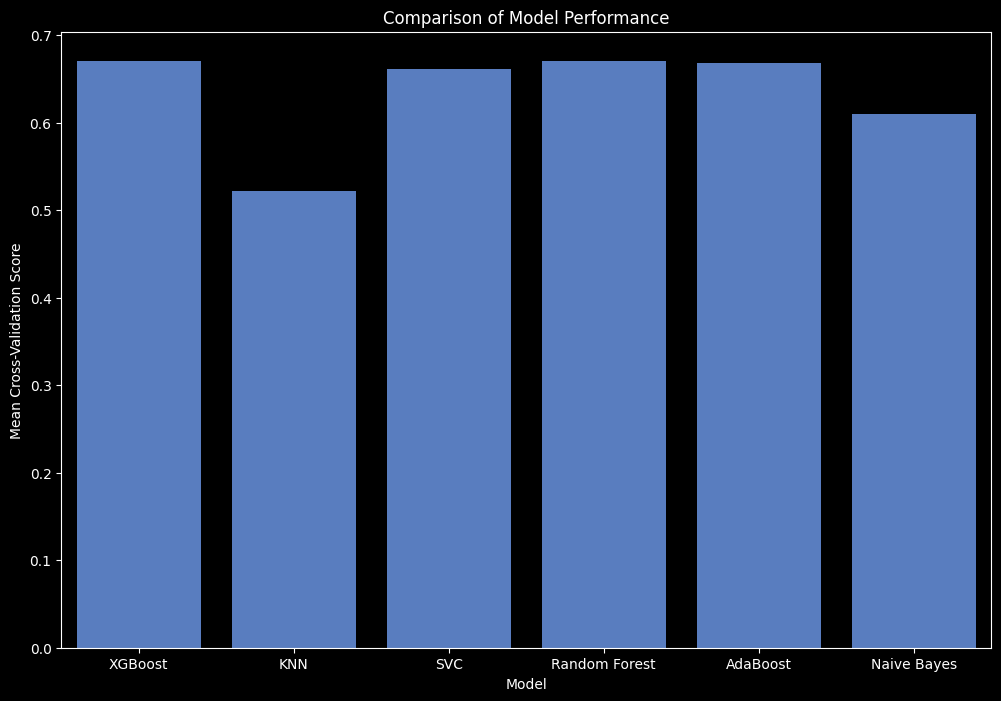

In [27]:
models = {
    "XGBoost": best_xgb_model,
    "KNN": best_knn_model,
    "SVC": best_svc_model,
    "Random Forest": best_rf_model,
    "AdaBoost": best_ada_model,
    "Naive Bayes": best_nb_model
}


models_performance = {
    "XGBoost": best_xgb_score,
    "KNN": best_knn_score,
    "SVC": best_svc_score,
    "Random Forest": best_rf_score,
    "AdaBoost": best_ada_score,
    "Naive Bayes": best_nb_score
}

# Plot the performance comparison
plt.figure(figsize=(12, 8))
sns.barplot(x=list(models_performance.keys()), y=list(models_performance.values()))
plt.title('Comparison of Model Performance')
plt.xlabel('Model')
plt.ylabel('Mean Cross-Validation Score')
plt.show()



XGBoost
------------
Confusion Matrix:
[[  53   26]
 [3003 2886]]
Precision: 0.9910714285714286
Recall: 0.4900662251655629
F1-Score: 0.6558345642540621
Cross-Validation Score: 0.6704810495626823


KNN
------------
Confusion Matrix:
[[   0   79]
 [   0 5889]]
Precision: 0.9867627345844504
Recall: 1.0
F1-Score: 0.9933372691237244
Cross-Validation Score: 0.5224489795918368


SVC
------------
Confusion Matrix:
[[  65   14]
 [3215 2674]]
Precision: 0.9947916666666666
Recall: 0.4540669043980302
F1-Score: 0.6235280401072636
Cross-Validation Score: 0.6611151603498542


Random Forest
------------
Confusion Matrix:
[[  53   26]
 [3001 2888]]
Precision: 0.9910775566231984
Recall: 0.4904058413992189
F1-Score: 0.6561399522889924
Cross-Validation Score: 0.670298833819242


AdaBoost
------------
Confusion Matrix:
[[  57   22]
 [3059 2830]]
Precision: 0.9922861150070126
Recall: 0.4805569706231958
F1-Score: 0.647523166685734
Cross-Validation Score: 0.668768221574344


Naive Bayes
------------
Confusio

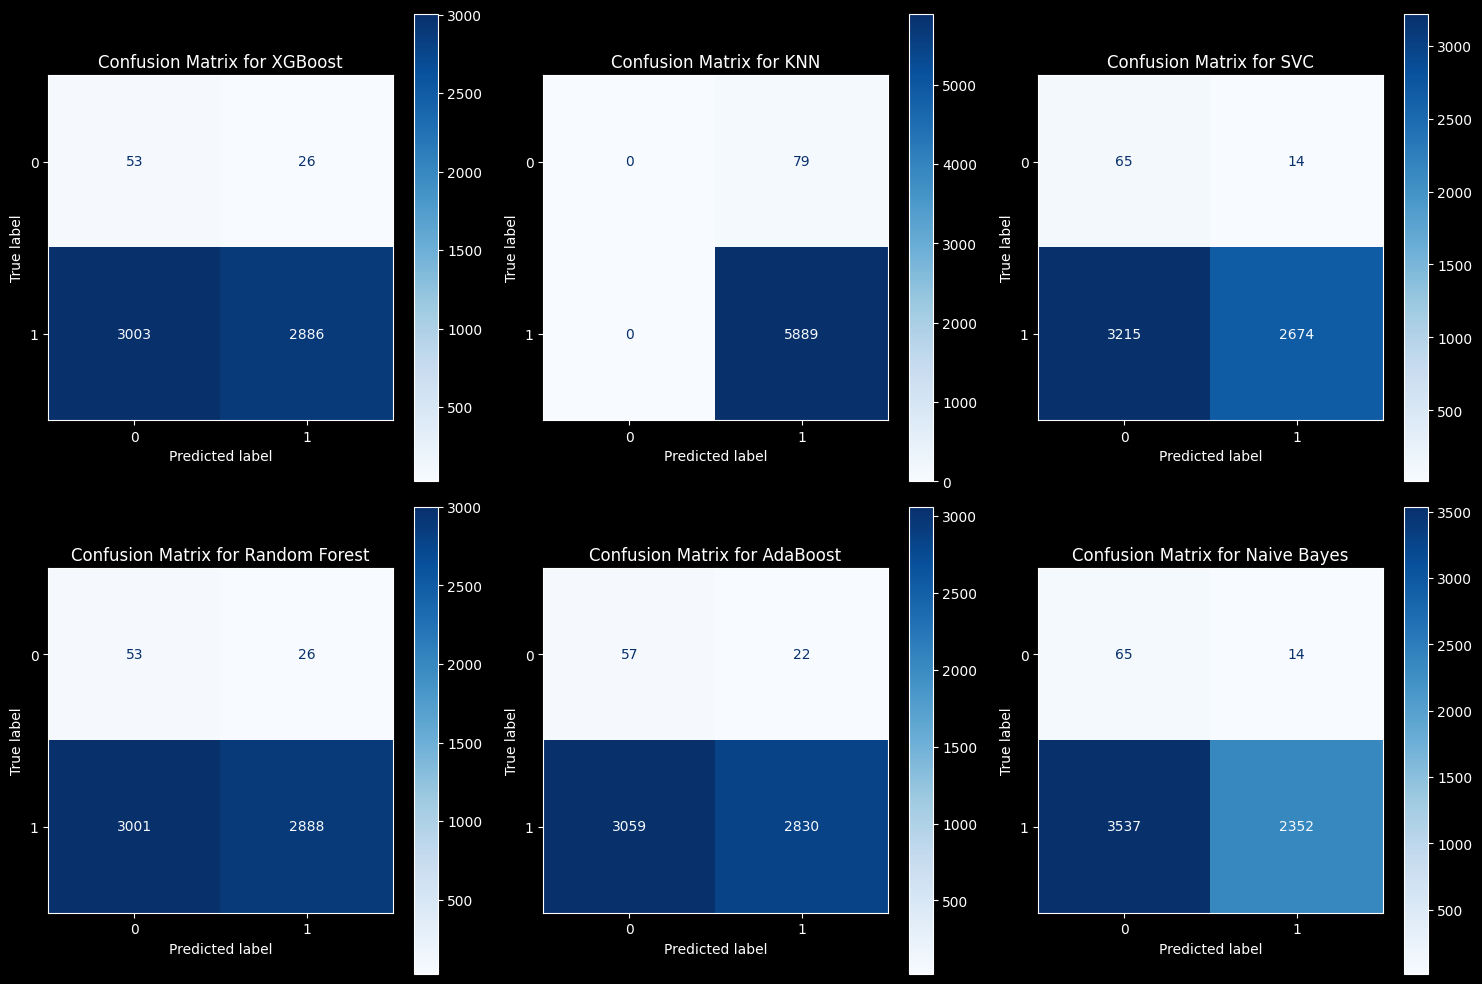

In [28]:
def evaluate_model(models, models_performance, x_test, y_test):
    # Create subplots for confusion matrices
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the grid size according to the number of models
    axes = axes.flatten()  # Flatten to make indexing easier
    
    for i, (key, model) in enumerate(models.items()):
        # Make predictions with the model
        y_pred = models[key].predict(x_test)

        # Calculate metrics
        cm = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Print metrics
        print(f"\n{key}\n------------")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
        print(f"Cross-Validation Score: {models_performance[key]}\n")
        
        # Plot confusion matrix
        plot_confusion_matrix(models[key], x_test, y_test, ax=axes[i], cmap="Blues")
        axes[i].set_title(f"Confusion Matrix for {key}")
    
    # Adjust the layout to avoid overlap
    plt.tight_layout()
    plt.show()



# Example usage with the models and performance dictionaries
evaluate_model(models, models_performance, x_test, y_test)






## Final Model Recommendation

In [29]:
best_model_name = max(models_performance, key=models_performance.get)
print(f"The best model based on the cross-validation score is: {best_model_name}")

# If you need to retrieve the best model, here it is:
if best_model_name == "XGBoost":
    final_model = best_xgb_model
elif best_model_name == "KNN":
    final_model = best_knn_model
elif best_model_name == "SVC":
    final_model = best_svc_model
elif best_model_name == "Random Forest":
    final_model = best_rf_model
elif best_model_name == "AdaBoost":
    final_model = best_ada_model
else:
    final_model = best_nb_model

print(f"Final best model: {final_model}")

The best model based on the cross-validation score is: XGBoost
Final best model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [32]:
model_ui_filename = f"../deployment-ui/data/{best_model_name}_model.joblib"
model_filename = f"../data/{best_model_name}_model.joblib"
# dump(final_model, model_ui_filename)
# dump(final_model, model_filename)
final_model.save_model(model_ui_filename)
final_model.save_model(model_filename)

print(f"Model saved as: {model_filename}")

Model saved as: ../data/XGBoost_model.joblib


In [37]:

# Load the saved model
model_path = "../data/XGBoost_model.joblib"
loaded_model = load(model_path)

# Test the loaded model
sample_predictions = loaded_model.predict(x_test[:10])
print(f"Features: \n{x_test[:10]}\n\nSample Predictions: \n{sample_predictions}\n\n")

actual_labels = y_test[:10]
print(f"Actual Labels: \n{actual_labels}")


Features: 
[[0.21683468 0.         0.02281172]
 [0.02099542 0.         0.00180441]
 [0.15923628 1.         0.0389178 ]
 [0.52353838 0.         0.01521137]
 [0.40431855 0.         0.01156293]
 [0.52353838 0.         0.01521137]
 [0.52353838 0.         0.01521137]
 [0.15923628 1.         0.0389178 ]
 [0.52353838 0.         0.01521137]
 [0.73014917 0.         0.01904945]]

Sample Predictions: 
[0 1 1 1 1 1 1 1 1 0]


Actual Labels: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
